# Comparing the connectivity matrices from experimental data with theoretical predictions

The networks from Ioannis's paper have 4 populations of neurons - 3 excitatory (PEG, PEN, EPG) and 1 inhibitory (Delta7) while the theoretical work assumes only a single population of neurons that can have both excitatory and inhibitory connections.

Therefore, we simplify the connections in the 4-population network to produce an equivalent 1-population network so we can compare our predictions to the experimental results. This process is:
* considering the EPG neurons as the basis of the network, as they are in the ellipsoid body in the fly (ie. the ring)
* counting the number of paths through the 4 population that link 2 EPG neurons, and keeping track of the signs of these paths
* creating a new network of just EPG neurons with these same connections, weighted inversely depending on the path length gives us an equivalent 1-population network

In [7]:
import networkx as nx
import connectivity_matrices
import numpy as np
import numpy.lib.stride_tricks
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.path
import matplotlib.font_manager
import scipy.linalg
import scipy.optimize
import itertools

plt.style.use('seaborn-v0_8-notebook')
%matplotlib inline
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [8,6]) # paper figures should be width 8 (full linewidth) to have nicely readable text
plt.rc('figure', facecolor = 'white') # otherwise background is transparent?

In [8]:
neuron_colours = {
	'EPG': '#eaf304',
	'PEN': '#32d376',
	'PEG': '#f87a4a',
	'D7': '#51b1e3',
}
neuron_name_to_type = lambda name: name.split('_')[0] # PEN, PEG, EPG, D7
neuron_name_to_type_index = lambda name: ['PEN', 'PEG', 'EPG', 'D7'].index(neuron_name_to_type(name)) # 0, 1, 2, 3
neuron_name_to_side = lambda name: name.split('_')[1][0] # L or R
neuron_index_from_side_number = lambda side_number: side_number[1:] if side_number.startswith('L') or side_number.startswith('R') else side_number
neuron_name_to_index = lambda name: int(neuron_index_from_side_number(name.split('_')[1])) # 1, 2, ...
color_graph = lambda g: [neuron_colours[neuron_name_to_type(node)] for node in g.nodes]
color_edges = lambda g: [('#8888dd' if g.edges[edge]['weight'] < 0 else '#dd6666') for edge in g.edges]

neuron_names = [f'{type}_{n}' for type in ['PEN','PEG','EPG','D7'] for n in range(1,9)]
EPG_neuron_indices = np.where([name.startswith('EPG') for name in neuron_names])[0]
cos_sin = lambda angle: np.array([np.cos(angle), np.sin(angle)])
neuron_type_magnitude = lambda name: [1.7, 1.7, 2.2, 1.2][neuron_name_to_type_index(name)] # PEN, PEG, EPG, D7
neuron_type_phase = lambda name: [0.75, 1.25, 1, 1][neuron_name_to_type_index(name)] # PEN, PEG, EPG, D7
neuron_pos = {name: neuron_type_magnitude(name)*cos_sin(2*np.pi*(neuron_name_to_index(name)+neuron_type_phase(name))/8) for name in neuron_names}

profile_to_matrix = lambda profile: scipy.linalg.circulant(profile)
get_cosine_from_fourier_spectrum = lambda fourier_spectrum: np.fft.ifft(fourier_spectrum).real
circular_concat = lambda x : np.hstack((x, x[0]))

N = 8
neuron_indices = np.arange(N)

In [9]:
# graph drawing

def draw_recurrent_edges(ax, edges, weights, positions, scale=1.0, **kwargs):
	def _connectionstyle(posA, posB, *args, **kwargs):
		# Copied from NetworkX plotting code - modified to look nicer
		assert np.all(posA == posB), ValueError('Start and end positions of recurrent edge don\'t match')
		data_loc = posA
		v_shift = 18*scale
		h_shift = v_shift * 0.5
		# put the top of the loop first so arrow is not hidden by node
		path = [
			# 1
			data_loc + np.asarray([0, v_shift]),
			# 4 4 4
			data_loc + np.asarray([h_shift, v_shift]),
			data_loc + np.asarray([h_shift, 0]),
			data_loc,
			# 4 4 4
			data_loc + np.asarray([-h_shift, 0]),
			data_loc + np.asarray([-h_shift, v_shift]),
			data_loc + np.asarray([0, v_shift]),
		]
		return matplotlib.path.Path(path, [1, 4, 4, 4, 4, 4, 4])

	for edge, weight in zip(edges, weights):
		pos = positions[edge[0]]

		arrow = matplotlib.patches.FancyArrowPatch(
			pos,
			pos,
			connectionstyle=_connectionstyle,
			linewidth=weight,
			**kwargs
		)
		ax.add_patch(arrow)

def draw_graph(g, ax=None, small_nodes=False, only_show_indices=False, node_size=500, recurrent_connection_scale=None):
	if ax is None:
		ax = plt.gca()
	pos = nx.get_node_attributes(g, 'pos')
	node_colours = color_graph(g)
	weights = np.array(list(nx.get_edge_attributes(g, 'weight').values())) / 2
	edges = np.array(g.edges)
	bidirectional_edges = np.array([(edge[::-1] in list(g.edges) or (edge[1],edge[0],0) in list(g.edges)) for edge in list(g.edges)])
	PEN_EPG_edges = np.array([(edge[0].startswith('PEN') and edge[1].startswith('EPG') and neuron_name_to_index(edge[0]) != neuron_name_to_index(edge[1])) for edge in list(g.edges)])
	PEN_EPG_edges_next = np.array([(edge[0].startswith('PEN') and edge[1].startswith('EPG') and neuron_name_to_index(edge[0])%8 == (1+neuron_name_to_index(edge[1]))%8) for edge in list(g.edges)])
	PEN_EPG_edges_prev = np.array([(edge[0].startswith('PEN') and edge[1].startswith('EPG') and neuron_name_to_index(edge[1])%8 == (1+neuron_name_to_index(edge[0]))%8) for edge in list(g.edges)])
	recurrent_connections = np.array([edge[0] == edge[1] for edge in list(g.edges)])
	node_size = 150 if small_nodes else node_size
	font_size = 16 if only_show_indices and not small_nodes else 12 if small_nodes else 8
	node_label_formatter = lambda node: f'${{{neuron_name_to_index(node)}}}$' if only_show_indices else f'{neuron_name_to_type(node)}${{}}_{{{neuron_name_to_index(node)}}}$'
	node_labels = {node: node_label_formatter(node) for node in g.nodes}
	nx.draw_networkx_nodes(g, ax=ax, pos=pos, node_size=node_size, alpha=1.0, node_color=node_colours, edgecolors='black')
	nx.draw_networkx_labels(g, ax=ax, pos=pos, font_size=font_size, labels=node_labels)
	if len(edges):
		# plot bidirectional edges with some curvature so both are visible
		nx.draw_networkx_edges(g, ax=ax, pos=pos, node_size=int(node_size*1.15), edge_color='#dd3333', edgelist=edges[(weights > 0) & bidirectional_edges & ~PEN_EPG_edges & ~recurrent_connections], width=weights[(weights > 0) & bidirectional_edges & ~PEN_EPG_edges & ~recurrent_connections], connectionstyle="arc3,rad=0.15", arrowstyle=matplotlib.patches.ArrowStyle.CurveB(head_length=.15, head_width=.15))
		# plot unidirectional edges as straight lines
		nx.draw_networkx_edges(g, ax=ax, pos=pos, node_size=int(node_size*1.15), edge_color='#dd3333', edgelist=edges[(weights > 0) & ~bidirectional_edges & ~PEN_EPG_edges & ~recurrent_connections], width=weights[(weights > 0) & ~bidirectional_edges & ~PEN_EPG_edges & ~recurrent_connections], connectionstyle="arc3,rad=0", arrowstyle=matplotlib.patches.ArrowStyle.CurveB(head_length=.15, head_width=.15))
		# plot PEN to EPG edges with custom curvature so they look nice (depends on the direction)
		nx.draw_networkx_edges(g, ax=ax, pos=pos, node_size=int(node_size*1.15), edge_color='#dd3333', edgelist=edges[PEN_EPG_edges_next], width=weights[PEN_EPG_edges_next], connectionstyle="arc3,rad=-0.2", arrowstyle=matplotlib.patches.ArrowStyle.CurveB(head_length=.15, head_width=.15))
		nx.draw_networkx_edges(g, ax=ax, pos=pos, node_size=int(node_size*1.15), edge_color='#dd3333', edgelist=edges[PEN_EPG_edges_prev], width=weights[PEN_EPG_edges_prev], connectionstyle="arc3,rad=0.2", arrowstyle=matplotlib.patches.ArrowStyle.CurveB(head_length=.15, head_width=.15))
		# plot inhibitory connections with bars instead of arrow heads
		nx.draw_networkx_edges(g, ax=ax, pos=pos, node_size=int(node_size*1.25), edge_color='#3333dd', edgelist=edges[(weights < 0) & bidirectional_edges & ~recurrent_connections], width=-weights[(weights < 0) & bidirectional_edges & ~recurrent_connections], connectionstyle="arc3,rad=0.05", arrowstyle=matplotlib.patches.ArrowStyle.BarAB(widthA=0, widthB=0.15))
		nx.draw_networkx_edges(g, ax=ax, pos=pos, node_size=int(node_size*1.25), edge_color='#3333dd', edgelist=edges[(weights < 0) & ~bidirectional_edges & ~recurrent_connections], width=-weights[(weights < 0) & ~bidirectional_edges & ~recurrent_connections], connectionstyle="arc3,rad=0", arrowstyle=matplotlib.patches.ArrowStyle.BarAB(widthA=0, widthB=0.15))
	
		# Need to override NetworkX's recurrent loop plotting because the scaling is broken...
		if not recurrent_connection_scale:
			recurrent_connection_scale = 0.6 if small_nodes else 1.0
		draw_recurrent_edges(ax, edges[(weights < 0) & recurrent_connections], -weights[(weights < 0) & recurrent_connections], pos, scale=recurrent_connection_scale, color='#3333dd', arrowstyle=matplotlib.patches.ArrowStyle.BarAB(widthA=0, widthB=2))
		draw_recurrent_edges(ax, edges[(weights > 0) & recurrent_connections], weights[(weights > 0) & recurrent_connections], pos, scale=recurrent_connection_scale, color='#dd3333', arrowstyle=matplotlib.patches.ArrowStyle.CurveB(head_length=2, head_width=2))
	
	ax.axis('off')
	ax.axis('equal')

get_graph_edges = lambda M: [(neuron_names[pre],neuron_names[post], {'weight': M[pre,post]}) for pre in range(len(neuron_names)) for post in range(len(neuron_names)) if M[pre,post] != 0]
subset_graph_edges_EPG1 = lambda edges: [(pre,post,weight) for pre,post,weight in edges if pre == 'EPG_1' and post.startswith('EPG')]
subset_graph_edges_EPG = lambda edges: [(pre,post,weight) for pre,post,weight in edges if pre.startswith('EPG') and post.startswith('EPG')]
make_graph_from_matrix = lambda M: nx.DiGraph([(neuron_names[pre],neuron_names[post], {'weight': M[pre,post]}) for pre in range(32) for post in range(32) if M[pre,post] != 0])

def get_graph_paths_with_length(M, l):
	# Need to transpose the matrix to [post,pre] so that we can eg. get paths of length 2 by squaring the matrix
	M = M.T
	edge_list = []

	for connections in itertools.product([M * (M > 0),M * (M < 0)], repeat=l):
		connectivity_matrix = connections[0]
		if l > 1:
			for next_m in connections[1:]:
				EPG_neurons_slice = slice(EPG_neuron_indices[0], EPG_neuron_indices[-1]+1)
				connectivity_matrix[EPG_neurons_slice,EPG_neurons_slice] = 0 # terminate all the paths that have reached an EPG neuron already
				connectivity_matrix = connectivity_matrix @ next_m
		edges = get_graph_edges(connectivity_matrix.T) # transpose back to [pre,post] to work with the rest of the functions
		edge_list += subset_graph_edges_EPG(edges)
	return edge_list

def plot_graph_simplification(M, path_lengths, axs):
	full_graph = make_graph_from_matrix(M)
	combined_edges = []
	path_length_graphs = []
	for path_length in path_lengths:
		edges = get_graph_paths_with_length(M, path_length)
		graph = nx.MultiDiGraph(edges)
		combined_edges += edges
		path_length_graphs.append(graph)
	combined_graph = nx.MultiDiGraph(combined_edges)

	for n, graph in enumerate([full_graph, *path_length_graphs, combined_graph]):
		nx.set_node_attributes(graph, neuron_pos, name='pos')
		draw_graph(graph, axs[n], small_nodes=n>0 and n<len(axs)-1, only_show_indices=n>0 and n<len(axs)-1)
	axs[0].set_title('Biological connectivity')
	axs[-1].set_title('Simplified connectivity')
	for n, path_length in enumerate(path_lengths):
		axs[n+1].set_title(f'Paths of length {path_length}')
		axs[n+1].set_xlim([axs[1].get_xlim()[0]-0.1, axs[1].get_xlim()[1]+0.1])

	return combined_graph

# going from graph to connectivity matrix profile
def roll_matrix_rows(matrix, roll_amounts):
	'''roll each row of a 2D matrix by an independent amount, as specified in `roll_amounts`.'''
	matrix_rolled = matrix[:, [*range(matrix.shape[1]),*range(matrix.shape[1]-1)]].copy()
	stride_0, stride_1 = matrix_rolled.strides
	num_cols = matrix.shape[1]
	result = numpy.lib.stride_tricks.as_strided(matrix_rolled, (*matrix.shape, num_cols), (stride_0 ,stride_1, stride_1))
	return result[np.arange(matrix.shape[0]), (num_cols-roll_amounts) % num_cols]

def get_circulant_matrix_profile(matrix):
	N = np.arange(matrix.shape[0])
	unrolled_matrix = roll_matrix_rows(matrix, -N)

	mu = unrolled_matrix.mean(axis=0)
	stddev = np.sqrt(unrolled_matrix.var(axis=0))

	return mu, stddev

def plot_circulant_matrix_as_profile(matrix, plot_stddev=True, plot_all_profiles=False, roll=False, show=True):
	N = np.arange(matrix.shape[0]+1)
	mu, stddev = get_circulant_matrix_profile(matrix)
	if roll:
		N -= matrix.shape[0]//2
		mu = np.roll(mu, matrix.shape[0]//2)
		stddev = np.roll(stddev, matrix.shape[0]//2)

	if plot_all_profiles:
		unrolled_matrix = roll_matrix_rows(matrix, (matrix.shape[0]//2 if roll else 0) - np.arange(matrix.shape[0]))
		plt.plot(N, np.vstack((unrolled_matrix.T, unrolled_matrix.T[:,0])), 'k', alpha=0.2)

	plt.plot(N, circular_concat(mu), 'o--', markersize=6, linewidth=1)
	if plot_stddev:
		plt.fill_between(N, circular_concat(mu-stddev), circular_concat(mu+stddev), alpha=0.2)
	if show:
		plt.show()
	return mu

def graph_to_connectivity_matrix(g, nodes):
	connectivity_matrix = np.zeros((len(nodes),len(nodes)))

	for edge,weight in nx.get_edge_attributes(g, 'weight').items():
		connectivity_matrix[nodes.index(edge[0]),nodes.index(edge[1])] += weight
	return connectivity_matrix

def profile_to_mu_amp_phase(profile):
	# using vector population code readout
	# first remove the mean, then array the profile around a circle and find the angle and vector magnitude
	# for a sinusoid of amplitude 1, the total length will be 4 (2 + 4(sqrt(2)/2)^2), so normalise by this
	mu = profile.mean()
	x = np.sum((profile - mu) * np.cos(2*np.pi*np.arange(len(profile))/len(profile)))
	y = np.sum((profile - mu) * np.sin(2*np.pi*np.arange(len(profile))/len(profile)))
	return mu, np.sqrt(x**2 + y**2)/4, len(profile)/(2*np.pi)*np.arctan2(y, x)

# for fitting the best sinusoid to each

precision_weighted_SSE = lambda x, y, sigma: lambda amp, mean: np.sum(((amp*x+mean - y)/sigma)**2)

def MLE(x, y, sigma):
	'''
	Get the Maximum Likelihood parameter estimate that minimises the sum of squared precision weighted errors. ie. the loss function: 
	`L = sum( ((A*x_n + B - y_n) / sigma_n)**2 )`

	Returns [A,B]
	'''
	J = np.array([[np.sum(x**2/sigma), np.sum(x/sigma)],[np.sum(x/sigma),np.sum(1/sigma)]])
	k = np.array([[np.sum(x*y/sigma)], [np.sum(y/sigma)]])
	return np.linalg.solve(J, k)

def MLE_optimised(x, y, sigma):
	return scipy.optimize.minimize((lambda loss_function: lambda x: loss_function(*x))(precision_weighted_SSE(x, y, sigma)), [0,0]).x

## Visualising the theoretical networks with different harmonics

For each network that uses a single harmonic, we visualise its connectivity graph

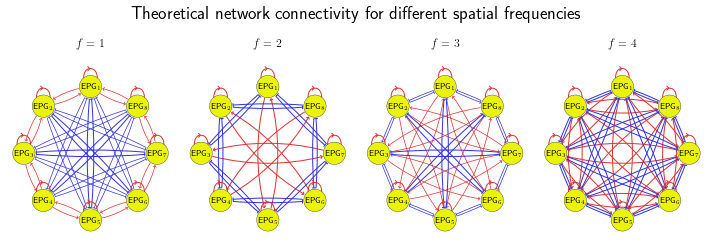

In [4]:
f_range = range(1,5)
fig,axs = plt.subplots(1, len(f_range), figsize=(10,3.5))
for i, f in enumerate(f_range):
	W = profile_to_matrix(2/N * np.cos(2*f*np.pi*neuron_indices/N))
	edges = [(f'EPG_{i+1}', f'EPG_{j+1}', {'weight': 8*W[i][j]}) for i in range(N) for j in range(N) if abs(W[i][j]) > 1e-6]
	g = nx.DiGraph(edges)
	nx.set_node_attributes(g, neuron_pos, name='pos')
	draw_graph(g, axs[i])
	axs[i].set_title(f'$f={f}$')

plt.suptitle('Theoretical network connectivity for different spatial frequencies', fontsize=18)
plt.tight_layout()
plt.show()

Interestingly, 
* $f=2$ - the network is actually two independent disconnected networks - $[1,3,5,7]$ and $[2,4,6,8]$
* $f=3$ - counting the connections to and from each neurons, we see that it is the same as the $f=1$ network
* $f=4$ - there are two groups of neurons connected with excitatory connections, each inhibiting the other group

We can change the position of the neurons to better visualise these observations

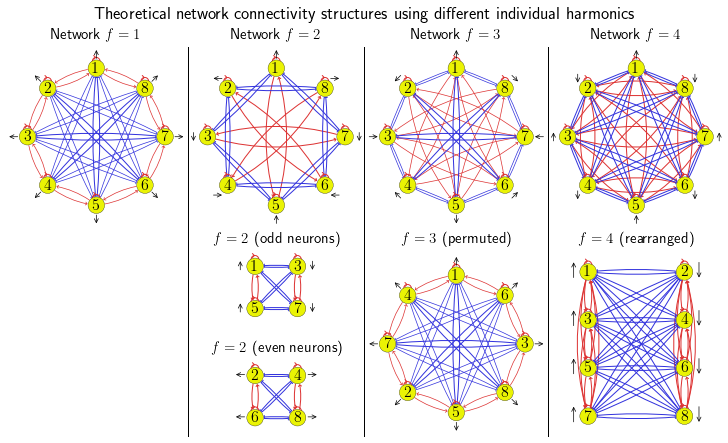

In [6]:
figsize=(10,6)
fig, axs = plt.subplot_mosaic("ABCD;.EGH;.FGH", figsize=figsize, height_ratios=[1.2,1/2,1/2], constrained_layout=True)
axs = np.array(list(axs.values()))[np.argsort(list(axs.keys()))] # need to do this to get axes in order A B C D ...
# fig,axs = plt.subplots(3, len(f_range), figsize=(15,10))

f_range = range(1,5)
for i, f in enumerate(f_range):
	W = profile_to_matrix(2/N * np.cos(2*f*np.pi*neuron_indices/N))
	edges = [(f'EPG_{i+1}', f'EPG_{j+1}', {'weight': 8*W[i][j]}) for i in range(N) for j in range(N) if abs(W[i][j]) > 1e-6]
	g = nx.DiGraph(edges)
	nx.set_node_attributes(g, neuron_pos, name='pos')
	draw_graph(g, axs[i], only_show_indices=True, node_size=275, recurrent_connection_scale=0.6)
	axs[i].set_title(f'Network $f={f}$', fontsize=figsize[0]/8*12) # scale up font size as if the figure were 8 inches wide (to match other figures)

g2 = (lambda W: nx.DiGraph([(f'EPG_{i+1}', f'EPG_{j+1}', {'weight': 8*W[i][j]}) for i in range(N) for j in range(N) if abs(W[i][j]) > 1e-6])) \
		(profile_to_matrix(2/N * np.cos(2*2*np.pi*neuron_indices/N)))
g3 = (lambda W: nx.DiGraph([(f'EPG_{i+1}', f'EPG_{j+1}', {'weight': 8*W[i][j]}) for i in range(N) for j in range(N) if abs(W[i][j]) > 1e-6])) \
		(profile_to_matrix(2/N * np.cos(2*3*np.pi*neuron_indices/N)))
g4 = (lambda W: nx.DiGraph([(f'EPG_{i+1}', f'EPG_{j+1}', {'weight': 8*W[i][j]}) for i in range(N) for j in range(N) if abs(W[i][j]) > 1e-6])) \
		(profile_to_matrix(2/N * np.cos(2*4*np.pi*neuron_indices/N)))

# nx.set_node_attributes(g2, neuron_pos, name='pos')
nx.set_node_attributes(g2, {name: [[-1/2,1],[-1/2,1],[1/2,1],[1/2,1],[-1/2,0],[-1/2,0],[1/2,0],[1/2,0]][neuron_name_to_index(name)-1] for name in neuron_names}, name='pos')
g2_odd = g2.copy()
g2_even = g2.copy()
for n in range(2,9,2):
	g2_odd.remove_node(f'EPG_{n}')
for n in range(1,9,2):
	g2_even.remove_node(f'EPG_{n}')
draw_graph(g2_odd, axs[4], only_show_indices=True, node_size=275, recurrent_connection_scale=0.6)
axs[4].set_title('$f=2$ (odd neurons)', fontsize=figsize[0]/8*12) # scale up font size as if the figure were 8 inches wide (to match other figures)
axs[4].set_ylim(axs[4].get_ylim()[0]-0.4, axs[4].get_ylim()[1]+0.3) #manually fix this to not cut off the neuron
draw_graph(g2_even, axs[5], only_show_indices=True, node_size=275, recurrent_connection_scale=0.6)
axs[5].set_ylim(axs[4].get_ylim())
axs[5].set_title('$f=2$ (even neurons)', fontsize=figsize[0]/8*12) # scale up font size as if the figure were 8 inches wide (to match other figures)

nx.set_node_attributes(g3, {name: neuron_type_magnitude(name)*cos_sin(2*np.pi*([1,4,7,2,5,8,3,6][neuron_name_to_index(name)-1]+neuron_type_phase(name))/8) for name in neuron_names}, name='pos')
draw_graph(g3, axs[6], only_show_indices=True, node_size=275, recurrent_connection_scale=0.6)
axs[6].set_title('$f=3$ (permuted)', fontsize=figsize[0]/8*12) # scale up font size as if the figure were 8 inches wide (to match other figures)

nx.set_node_attributes(g4, {name: [[-1/2,1],[1/2,1],[-1/2,.5],[1/2,.5],[-1/2,0],[1/2,0],[-1/2,-.5],[1/2,-.5]][neuron_name_to_index(name)-1] for name in neuron_names}, name='pos')
draw_graph(g4, axs[7], only_show_indices=True, node_size=275, recurrent_connection_scale=0.6)
axs[7].set_title('$f=4$ (rearranged)', fontsize=figsize[0]/8*12) # scale up font size as if the figure were 8 inches wide (to match other figures)

plt.suptitle('Theoretical network connectivity structures using different individual harmonics', fontsize=figsize[0]/8*14) # scale up font size as if the figure were 8 inches wide (to match other figures)

for x in [0.255,0.5,0.755]:
	fig.add_artist(plt.Line2D([x, x], [0,0.9], color="black", lw=1))

arrow_length = 0.4
arrow_start = lambda centre, length, direction: centre - length/2*cos_sin(direction)
arrow_end = lambda centre, length, direction: centre + length/2*cos_sin(direction)
arrow_centre_length = 2.65
for n in range(N):
	arrow_centre = arrow_centre_length*cos_sin(2*np.pi*n/N + np.pi/2)
	for i, f in enumerate(range(1,5)):
		axs[i].annotate('', xy=arrow_start(arrow_centre, arrow_length, 2*f*np.pi*n/N + np.pi/2), xytext=arrow_end(arrow_centre, arrow_length, 2*f*np.pi*n/N + np.pi/2), arrowprops=dict(arrowstyle="<-", linewidth=0.7, color='k'), annotation_clip=False)
	axs[6].annotate('', xy=arrow_start(arrow_centre, arrow_length, 2*np.pi*n/N + np.pi/2), xytext=arrow_end(arrow_centre, arrow_length, 2*np.pi*n/N + np.pi/2), arrowprops=dict(arrowstyle="<-", linewidth=0.7, color='k'), annotation_clip=False)

for i, ax in enumerate(axs[4:6]):
	for j, x in enumerate([-0.85,0.85]):
		for y in [0,1]:
			direction = [np.pi/2, -np.pi/2, -np.pi, 0][2*i + j]
			ax.annotate('', xy=arrow_start(np.array([x,y+0.02]), 0.3, direction), xytext=arrow_end(np.array([x,y+0.02]), 0.3, direction), arrowprops=dict(arrowstyle="<-", linewidth=0.7, color='k'), annotation_clip=False)

for i, x in enumerate([-0.65,0.65]):
	for y in [-1/2, 0, 1/2, 1]:
		direction = [np.pi/2, -np.pi/2][i]
		axs[7].annotate('', xy=arrow_start(np.array([x,y+0.02]), arrow_length/2, direction), xytext=arrow_end(np.array([x,y+0.02]), arrow_length/2, direction), arrowprops=dict(arrowstyle="<-", linewidth=0.7, color='k'), annotation_clip=False)		

plt.savefig('plots/theoretical-network-permutations-with-arrows.pdf')

plt.show()

## Simplifying the experimental networks

Starting with the networks from Ioannis's paper for the fly and locust, we simplify them from 4 populations to 1 population by calculating the "effective connectivity" between pairs of EPG neurons in the network for path lengths greater than 1.

This gives us simplified 1 populations networks we can compare to the theoretical predictions

### Locust

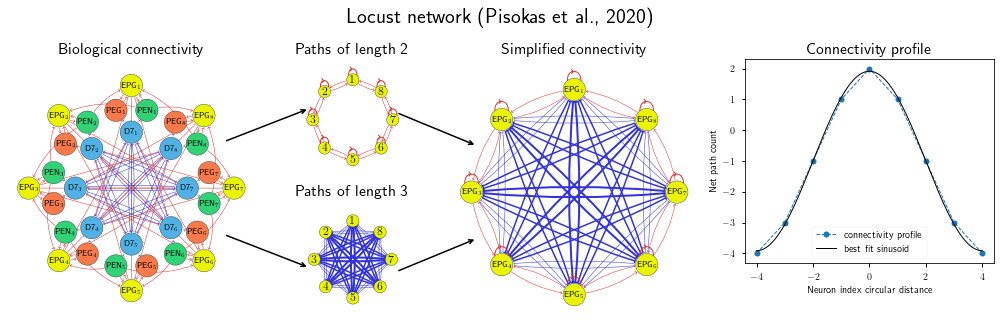

In [10]:
M_locust = connectivity_matrices.get_locust_simplified_connectivity_matrix_raw()

fig, axs = plt.subplot_mosaic("AABEEFF;AACEEFF", figsize=(14,5))
axs = np.array(list(axs.values()))[np.argsort(list(axs.keys()))] # need to do this to get axes in order A B C D ...
simplified_graph_locust = plot_graph_simplification(M_locust, [2,3], axs[:4])

simplified_connectivity_matrix_locust = graph_to_connectivity_matrix(simplified_graph_locust, sorted(list(simplified_graph_locust.nodes)))
plt.sca(axs[-1])
weight_profile_locust = plot_circulant_matrix_as_profile(simplified_connectivity_matrix_locust, plot_stddev=False, roll=True, show=False)
amp, mean = MLE(np.cos(2*np.pi/N*neuron_indices), weight_profile_locust, np.ones_like(weight_profile_locust)) # fit the best sinusoid

axs[-1].plot(x := np.linspace(-N//2,N//2,1000), mean + amp*np.cos(2*np.pi*x/N - np.pi), 'k-', linewidth=1)
axs[-1].legend(['connectivity profile','best fit sinusoid'])
axs[-1].set_xlabel('Neuron index circular distance')
axs[-1].set_ylabel('Net path count')
axs[-1].set_title('Connectivity profile')
plt.suptitle('Locust network (Pisokas et al., 2020)', fontsize=21)
for ax in axs:
	ax.set_title(ax.get_title(), fontsize=16)
plt.tight_layout()

# get the bottom of the axis label to match the bottom of the graph plots
axpos = axs[-1].get_position()
axpos.y0 = 0.27
axs[-1].set_position(axpos)

axs[0].annotate('', xy=(2.0,1), xytext=(3.8,1.7), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[0].annotate('', xy=(2.0,-1), xytext=(3.8,-1.7), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.1,1), xytext=(-3.8,1.7), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.1,-1), xytext=(-3.8,-1.7), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))

plt.show()

The locust network matches very closely the $f=1$ theoretical network, the only difference being the addition of some very weak inhibitory connections between neurons 90 degrees apart in the ring (eg. $\text{EPG}_1 \to \text{D7}_4 \to \text{PEN}_4 \to \text{EPG}_3$)

The connectivity profile confirms this

### Fruit fly

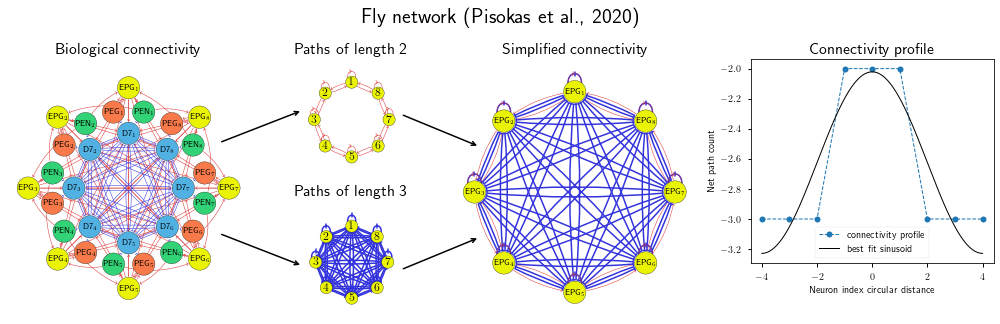

In [11]:
M_fly = connectivity_matrices.get_fly_simplified_connectivity_matrix_raw()

fig, axs = plt.subplot_mosaic("AABEEFF;AACEEFF", figsize=(14,5))
axs = np.array(list(axs.values()))[np.argsort(list(axs.keys()))] # need to do this to get axes in order A B C D ...
simplified_graph_fly = plot_graph_simplification(M_fly, [2,3], axs[:4])

simplified_connectivity_matrix_fly = graph_to_connectivity_matrix(simplified_graph_fly, sorted(list(simplified_graph_fly.nodes)))
plt.sca(axs[-1])
weight_profile_fly = plot_circulant_matrix_as_profile(simplified_connectivity_matrix_fly, plot_stddev=False, roll=True, show=False)
amp, mean = MLE(np.cos(2*np.pi/N*neuron_indices), weight_profile_fly, np.ones_like(weight_profile_fly)) # fit the best sinusoid

axs[-1].plot(x := np.linspace(-N//2,N//2,1000), mean + amp*np.cos(2*np.pi*x/N - np.pi), 'k-', linewidth=1)
axs[-1].legend(['connectivity profile','best fit sinusoid'])
axs[-1].set_xlabel('Neuron index circular distance')
axs[-1].set_ylabel('Net path count')
axs[-1].set_title('Connectivity profile')
plt.suptitle('Fly network (Pisokas et al., 2020)', fontsize=21)
for ax in axs:
	ax.set_title(ax.get_title(), fontsize=16)
plt.tight_layout()

# get the bottom of the axis label to match the bottom of the graph plots
axpos = axs[-1].get_position()
axpos.y0 = 0.27
axs[-1].set_position(axpos)

axs[0].annotate('', xy=(2.0,1), xytext=(3.8,1.7), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[0].annotate('', xy=(2.0,-1), xytext=(3.8,-1.7), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.1,1), xytext=(-3.8,1.7), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.1,-1), xytext=(-3.8,-1.7), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))

plt.show()

The fly network is structured somewhat similarly to the $f=1$ theoretical network in its excitatory connectivity, but the global inhibition of the fly network isn't consistent with the theoretical model.

Looking at the connectivity profile we see that the profile is not sinusoidal (assuming all synapses have equal strength).

We can check more detailed connectome data for the fruit fly to compare to our prediction

### Fly (Janelia connectome)

Looking at the connectivity derived from the Janelia connectome (and scaling the synapse counts down by 1000 to make the plotting look OK)

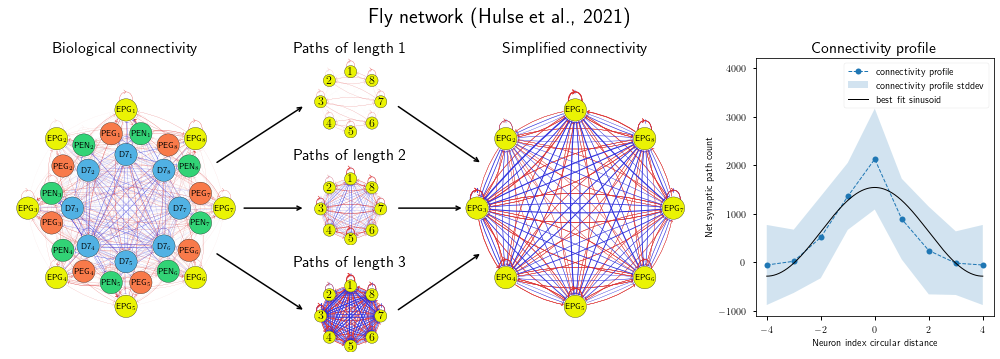

In [12]:
synapse_count_scaling = 1000
M_fly_janelia = connectivity_matrices.get_fly_janelia_one_sided_8_neurons_connectivity_matrix_raw() / synapse_count_scaling
M_fly_janelia[connectivity_matrices.FLY_JANELIA_ONE_SIDED_8_NEURONS.SLICE_D7,:] = -M_fly_janelia[connectivity_matrices.FLY_JANELIA_ONE_SIDED_8_NEURONS.SLICE_D7,:]

fig, axs = plt.subplot_mosaic("AABFFGG;AACFFGG;AADFFGG", figsize=(14,5.5))
axs = np.array(list(axs.values()))[np.argsort(list(axs.keys()))] # need to do this to get axes in order A B C D ...
simplified_graph_fly_janelia = plot_graph_simplification(M_fly_janelia, [1,2,3], axs[:5])

simplified_connectivity_matrix_fly_janelia = graph_to_connectivity_matrix(simplified_graph_fly_janelia, sorted(list(simplified_graph_fly_janelia.nodes))) * synapse_count_scaling
plt.sca(axs[-1])
plot_circulant_matrix_as_profile(simplified_connectivity_matrix_fly_janelia, plot_stddev=True, roll=True, show=False)
weight_profile_fly_janelia, sigma_weight_profile_fly_janelia = get_circulant_matrix_profile(simplified_connectivity_matrix_fly_janelia)
amp, mean = MLE(np.cos(2*np.pi/N*neuron_indices), weight_profile_fly_janelia, sigma_weight_profile_fly_janelia) # fit the best sinusoid

axs[-1].plot(x := np.linspace(-N//2,N//2,1000), mean + amp*np.cos(2*np.pi*x/N), 'k-', linewidth=1)
axs[-1].legend(['connectivity profile','connectivity profile stddev','best fit sinusoid'])
axs[-1].set_xlabel('Neuron index circular distance')
axs[-1].set_ylabel('Net synaptic path count')
axs[-1].set_ylim(-1100,4200)
axs[-1].set_title('Connectivity profile')
plt.suptitle('Fly network (Hulse et al., 2021)', fontsize=21)
for ax in axs:
	ax.set_title(ax.get_title(), fontsize=16)
plt.tight_layout()

# get the bottom of the axis label to match the bottom of the graph plots
axpos = axs[-1].get_position()
axpos.y0 = 0.2
axs[-1].set_position(axpos)

axs[0].annotate('', xy=(2.0,1), xytext=(4.0,2.3), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[0].annotate('', xy=(2.6,0), xytext=(4.0,0), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[0].annotate('', xy=(2.0,-1), xytext=(4.0,-2.3), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.1,1), xytext=(-4.0,2.3), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.5,0), xytext=(-4.0,0), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.1,-1), xytext=(-4.0,-2.3), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))

plt.show()

To find the best fit to the connectivity profile, we construct a maximum likelihood estimator to minimise the precision weighted sum of squared errors for each weight value:

$$L = \sum_n \left(\frac{A \cos(2\pi n/N) + B - \omega_n}{\sigma_n}\right)^2$$

Deriving this with respect to both $A$ and $B$ we get:

$$\begin{aligned}
	\frac{\partial L}{\partial A}	&= 2A \sum_n \frac{\cos^2(2\pi n/N)}{\sigma_n} + 2B \sum_n \frac{\cos(2\pi n/N)}{\sigma_n} - 2\sum_n \frac{\cos(2\pi n/N) \omega_n}{\sigma_n} \\
	\frac{\partial L}{\partial B}	&= 2A \sum_n \frac{\cos(2\pi n/N)}{\sigma_n} + 2B \sum_n \frac{1}{\sigma_n} - 2\sum_n \frac{\omega_n}{\sigma_n}
\end{aligned}$$

The minimum loss is where both derivatives are zero:

$$\begin{aligned}
	0 &= \begin{bmatrix}
		\sum_n \frac{\cos^2(2\pi n/N)}{\sigma_n} & \sum_n \frac{\cos(2\pi n/N)}{\sigma_n} \\
		\sum_n \frac{\cos(2\pi n/N)}{\sigma_n} & \sum_n \frac{1}{\sigma_n}
	\end{bmatrix}
	\begin{bmatrix}
		A \\
		B
	\end{bmatrix}
	- 
	\begin{bmatrix}
		\sum_n \frac{\cos(2\pi n/N) \omega_n}{\sigma_n} \\
		\sum_n \frac{\omega_n}{\sigma_n}
	\end{bmatrix}
	\\
	\therefore
	\begin{bmatrix}
		A \\
		B
	\end{bmatrix} &= 
	\begin{bmatrix}
		\sum_n \frac{\cos^2(2\pi n/N)}{\sigma_n} & \sum_n \frac{\cos(2\pi n/N)}{\sigma_n} \\
		\sum_n \frac{\cos(2\pi n/N)}{\sigma_n} & \sum_n \frac{1}{\sigma_n}
	\end{bmatrix}^{-1}
	\begin{bmatrix}
		\sum_n \frac{\cos(2\pi n/N) \omega_n}{\sigma_n} \\
		\sum_n \frac{\omega_n}{\sigma_n}
	\end{bmatrix}
\end{aligned}$$

We find the best fit for 3 hypotheses - that the connectivity profile is a sinusoid with the fundamental frequency $f=1$, with the first harmonic $f=2$, or a combination of the two $f=1+2$.

Of these, the lowest loss is for the model with $f=1$ sinusoidal weights

log loss f=1:	0.826121771200823
log loss f=1+2:	1.5551737980103326
log loss f=2:	5.750486282537332


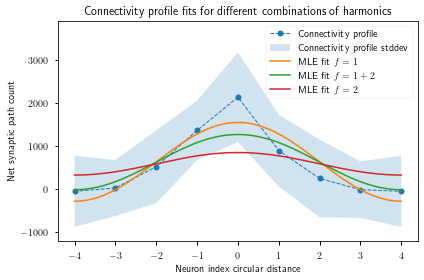

In [21]:
plt.figure(figsize=(6,4))
janelia_profile_mu, janelia_profile_stddev = get_circulant_matrix_profile(simplified_connectivity_matrix_fly_janelia)
roll_and_concat = lambda x: circular_concat(np.roll(x, N//2))

plt.plot(np.arange(-N//2, N//2+1), roll_and_concat(janelia_profile_mu), 'o--', markersize=6, linewidth=1, label='Connectivity profile')
plt.fill_between(np.arange(-N//2, N//2+1), roll_and_concat(janelia_profile_mu-janelia_profile_stddev), roll_and_concat(janelia_profile_mu+janelia_profile_stddev), alpha=0.2, label='Connectivity profile stddev')

for fs in [[1],[1,2],[2]]:
	x = np.sum([np.cos(2*f*np.pi/N*neuron_indices) for f in fs], axis=0)
	MLE_amp, MLE_mu = MLE(x, janelia_profile_mu, janelia_profile_stddev)
	plt.plot(i := np.linspace(-N//2,N//2,1000), MLE_mu + MLE_amp*np.cos(2*np.pi*i/N), linewidth=1.5, label=f'MLE fit $f={"+".join([str(f) for f in fs])}$')
	# plt.plot(np.arange(-N//2, N//2+1), roll_and_concat(MLE_amp * x + MLE_mu), 'o--', markersize=6, linewidth=1)
	print(f'log loss f={"+".join([str(f) for f in fs])}:\t{precision_weighted_SSE(x, janelia_profile_mu, janelia_profile_stddev)(MLE_amp, MLE_mu)}')
MLE_amp_f2, MLE_mu_f2 = MLE(np.cos(2*2*np.pi/N*neuron_indices), janelia_profile_mu, janelia_profile_stddev)
MLE_amp_f12, MLE_mu_f12 = MLE(np.cos(2*np.pi/N*neuron_indices)+np.cos(2*2*np.pi/N*neuron_indices), janelia_profile_mu, janelia_profile_stddev)

plt.title('Connectivity profile fits for different combinations of harmonics')
plt.xlabel('Neuron index circular distance')
plt.ylabel('Net synaptic path count')
plt.ylim(-1200,3900)
plt.legend()
plt.tight_layout()
plt.savefig('plots/fruit-fly-weight-profile-fit-comparison.pdf')
plt.show()

## Plot them all together

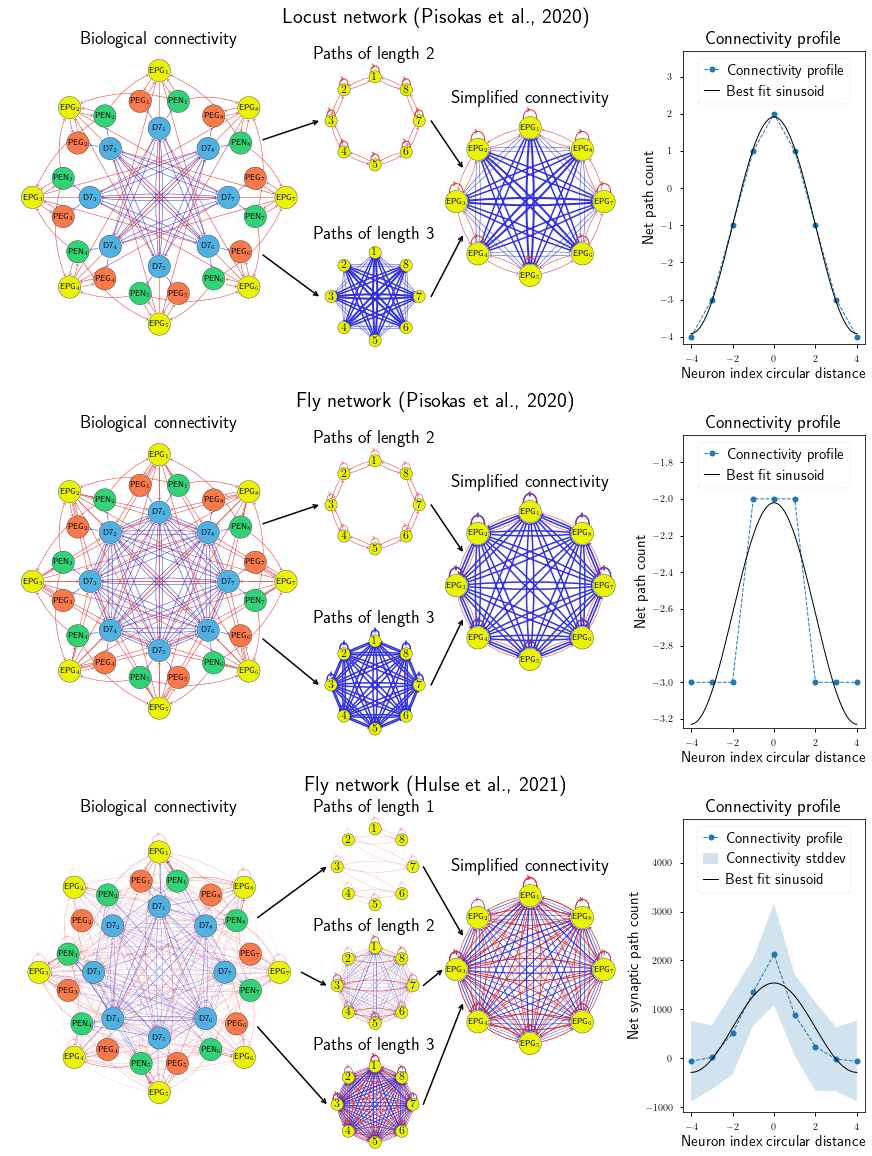

In [32]:
# Need to manually construct this gridspec to get things to plot nicely
figsize=(12,16)
fig = plt.figure(figsize=figsize, constrained_layout=True)
gridspec = fig.add_gridspec(6, 4, height_ratios=[0.1,1,0.1,1,0.1,1], width_ratios=[2.5,1,1.5,1.5])

plot1_paths = gridspec[5].subgridspec(2,1)
plot2_paths = gridspec[13].subgridspec(2,1)
plot3_paths = gridspec[21].subgridspec(3,1)

plot1_axs = [
    fig.add_subplot(gridspec[4]),
    fig.add_subplot(plot1_paths[0]),
    fig.add_subplot(plot1_paths[1]),
    fig.add_subplot(gridspec[6]),
    fig.add_subplot(gridspec[7]),
]
plot2_axs =[
	fig.add_subplot(gridspec[12]),
    fig.add_subplot(plot2_paths[0]),
    fig.add_subplot(plot2_paths[1]),
    fig.add_subplot(gridspec[14]),
    fig.add_subplot(gridspec[15]),
]
plot3_axs = [
	fig.add_subplot(gridspec[20]),
    fig.add_subplot(plot3_paths[0]),
    fig.add_subplot(plot3_paths[1]),
    fig.add_subplot(plot3_paths[2]),
    fig.add_subplot(gridspec[22]),
    fig.add_subplot(gridspec[23])
]

plot1_axs[2].sharex(plot1_axs[1])
plot2_axs[2].sharex(plot2_axs[1])
plot3_axs[2].sharex(plot3_axs[1])
plot3_axs[3].sharex(plot3_axs[1])

simplified_graph_locust = plot_graph_simplification(M_locust, [2,3], plot1_axs[:-1])
simplified_graph_fly = plot_graph_simplification(M_fly, [2,3], plot2_axs[:-1])
simplified_graph_fly_janelia = plot_graph_simplification(M_fly_janelia, [1,2,3], plot3_axs[:-1])

amp, mean = MLE(np.cos(2*np.pi/N*neuron_indices), weight_profile_fly_janelia, np.ones_like(weight_profile_fly_janelia)) # fit the best sinusoid
for n, (simplified_network, ax) in enumerate(zip([simplified_connectivity_matrix_locust, simplified_connectivity_matrix_fly, simplified_connectivity_matrix_fly_janelia], [plot1_axs[-1],plot2_axs[-1], plot3_axs[-1]])):
	plt.sca(ax)
	if n == 2:
		plot_circulant_matrix_as_profile(simplified_network, plot_stddev=True, roll=True, show=False)
		weight_profile, sigma_weight_profile = get_circulant_matrix_profile(simplified_connectivity_matrix_fly_janelia)
		amp, mean = MLE(np.cos(2*np.pi/N*neuron_indices), weight_profile, sigma_weight_profile) # fit the best sinusoid
	else:
		weight_profile = plot_circulant_matrix_as_profile(simplified_network, plot_stddev=False, roll=True, show=False)
		amp, mean = MLE(np.cos(2*np.pi/N*np.arange(-N//2,N//2)), weight_profile, np.ones_like(weight_profile)) # fit the best sinusoid
	ax.plot(x := np.linspace(-N//2,N//2,1000), mean + amp*np.cos(2*np.pi*x/N), 'k-', linewidth=1)
	# scale up font size as if the figure were 8 inches wide (to match other figures)
	ax.legend(['Connectivity profile','Best fit sinusoid'], loc='upper center', handlelength=1, handletextpad=0.5, fontsize=figsize[0]/8*10)
	ax.set_xlabel('Neuron index circular distance', fontsize=figsize[0]/8*10)
	ax.set_ylabel('Net path count' if n < 2 else 'Net synaptic path count', fontsize=figsize[0]/8*10)
	ax.set_title('Connectivity profile', fontsize=figsize[0]/8*12)
plot1_axs[-1].set_ylim(-4.2,3.7)
plot2_axs[-1].set_ylim(-3.25,-1.65)
plot3_axs[-1].set_ylim(-1100,4900)
plot3_axs[-1].legend(['Connectivity profile','Connectivity stddev','Best fit sinusoid'], loc='upper center', handlelength=1, handletextpad=0.5, fontsize=figsize[0]/8*10)

for ax in plot1_axs + plot2_axs + plot3_axs:
	ax.set_title(ax.get_title(), fontsize=figsize[0]/8*12)

plt.figtext(.5, 1-0.02, 'Locust network (Pisokas et al., 2020)', horizontalalignment='center', fontsize=figsize[0]/8*14)
plt.figtext(.5, 2/3-0.02, 'Fly network (Pisokas et al., 2020)', horizontalalignment='center', fontsize=figsize[0]/8*14)
plt.figtext(.5, 1/3-0.02, 'Fly network (Hulse et al., 2021)', horizontalalignment='center', fontsize=figsize[0]/8*14)

def set_title_y(ax, y):
	ax.set_title(ax.get_title(), fontsize=figsize[0]/8*12, y=y)

for n, plot_axs in enumerate([plot1_axs,plot2_axs,plot3_axs]):
	fig.patches.append(matplotlib.patches.ConnectionPatch((1.8,1), (-2.8,0), coordsA=plot_axs[0].transData, coordsB=plot_axs[1].transData, arrowstyle="->", linewidth=1.5, color='k'))
	fig.patches.append(matplotlib.patches.ConnectionPatch((1.8,-1), (-2.8,0), coordsA=plot_axs[0].transData, coordsB=plot_axs[-3].transData, arrowstyle="->", linewidth=1.5, color='k'))
	fig.patches.append(matplotlib.patches.ConnectionPatch((2.8,0), (-2,1), coordsA=plot_axs[1].transData, coordsB=plot_axs[-2].transData, arrowstyle="->", linewidth=1.5, color='k'))
	fig.patches.append(matplotlib.patches.ConnectionPatch((2.8,0), (-2,-1), coordsA=plot_axs[-3].transData, coordsB=plot_axs[-2].transData, arrowstyle="->", linewidth=1.5, color='k'))
	if n == 2:
		fig.patches.append(matplotlib.patches.ConnectionPatch((2.6,0), (-2.8,0), coordsA=plot_axs[0].transData, coordsB=plot_axs[2].transData, arrowstyle="->", linewidth=1.5, color='k'))
		fig.patches.append(matplotlib.patches.ConnectionPatch((2.8,0), (-2.6,0), coordsA=plot_axs[2].transData, coordsB=plot_axs[-2].transData, arrowstyle="->", linewidth=1.5, color='k'))
		set_title_y(plot_axs[1], y=0.9)
		set_title_y(plot_axs[2], y=0.9)
		set_title_y(plot_axs[3], y=0.9)
	else:
		set_title_y(plot_axs[1], y=0.8)
		set_title_y(plot_axs[2], y=0.8)
	set_title_y(plot_axs[-2], y=0.8)

for ax in plot3_axs[1:4]:
	ax.set_xlim(ax.get_xlim()[0]-0.1, ax.get_xlim()[1]+0.1)

plt.savefig('plots/network-graph-simplified-all.pdf')
plt.show()

## What if we don't combine PEG9 and PEG1, and EPG9 and EPG1

It's interesting to compare what happens if we remove the EPG9 and PEG9 entirely, instead of grouping them with EPG1 and PEG1 respectively. Does this have a big effect on the results?

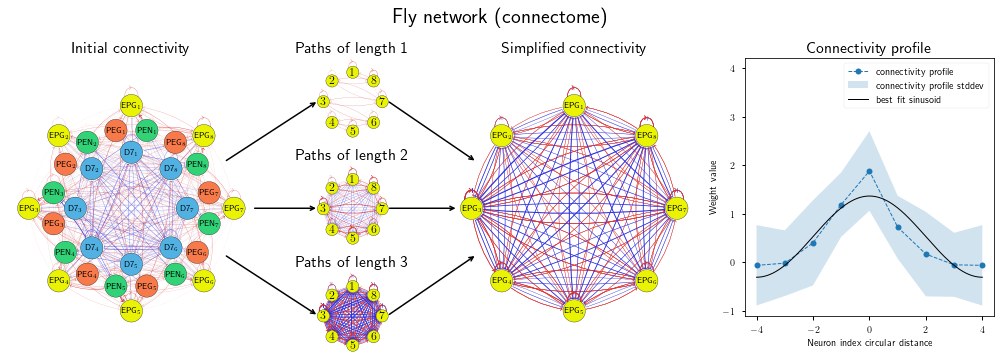

In [14]:
M_fly_janelia_9_neurons = connectivity_matrices.get_fly_janelia_one_sided_9_neurons_connectivity_matrix_raw() / 1000
M_fly_janelia_9_neurons[connectivity_matrices.FLY_JANELIA_ONE_SIDED_9_NEURONS.SLICE_D7,:] = -M_fly_janelia_9_neurons[connectivity_matrices.FLY_JANELIA_ONE_SIDED_9_NEURONS.SLICE_D7,:]
M_fly_janelia_9_neurons = np.delete(M_fly_janelia_9_neurons, connectivity_matrices.FLY_JANELIA_ONE_SIDED_9_NEURONS.SLICE_EPG.stop-1, 0)
M_fly_janelia_9_neurons = np.delete(M_fly_janelia_9_neurons, connectivity_matrices.FLY_JANELIA_ONE_SIDED_9_NEURONS.SLICE_EPG.stop-1, 1)
M_fly_janelia_9_neurons = np.delete(M_fly_janelia_9_neurons, connectivity_matrices.FLY_JANELIA_ONE_SIDED_9_NEURONS.SLICE_PEG.stop-1, 0)
M_fly_janelia_9_neurons = np.delete(M_fly_janelia_9_neurons, connectivity_matrices.FLY_JANELIA_ONE_SIDED_9_NEURONS.SLICE_PEG.stop-1, 1)

fig, axs = plt.subplot_mosaic("AABFFGG;AACFFGG;AADFFGG", figsize=(14,5.5))
axs = np.array(list(axs.values()))[np.argsort(list(axs.keys()))] # need to do this to get axes in order A B C D ...
simplified_graph_fly_janelia_9_neurons = plot_graph_simplification(M_fly_janelia_9_neurons, [1,2,3], axs[:5])

simplified_connectivity_matrix_fly_janelia_9_neurons = graph_to_connectivity_matrix(simplified_graph_fly_janelia_9_neurons, sorted(list(simplified_graph_fly_janelia_9_neurons.nodes)))
plt.sca(axs[-1])
weight_profile_fly_janelia_9_neurons = plot_circulant_matrix_as_profile(simplified_connectivity_matrix_fly_janelia_9_neurons, plot_stddev=True, roll=True, show=False)
amp, mean = MLE(np.cos(2*np.pi/N*neuron_indices), weight_profile_fly_janelia_9_neurons, np.ones_like(weight_profile_fly_janelia_9_neurons)) # fit the best sinusoid

axs[-1].plot(x := np.linspace(-N//2,N//2,1000), mean - amp*np.cos(2*np.pi*x/N), 'k-', linewidth=1)
axs[-1].legend(['connectivity profile','connectivity profile stddev','best fit sinusoid'])
axs[-1].set_xlabel('Neuron index circular distance')
axs[-1].set_ylabel('Net synaptic path count')
axs[-1].set_ylim(-1.1,4.2)
axs[-1].set_title('Connectivity profile')
plt.suptitle('Fly network (Hulse et al., 2021)', fontsize=21)
for ax in axs:
	ax.set_title(ax.get_title(), fontsize=16)
plt.tight_layout()

# get the bottom of the axis label to match the bottom of the graph plots
axpos = axs[-1].get_position()
axpos.y0 = 0.2
axs[-1].set_position(axpos)

axs[0].annotate('', xy=(2.0,1), xytext=(4.0,2.3), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[0].annotate('', xy=(2.6,0), xytext=(4.0,0), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[0].annotate('', xy=(2.0,-1), xytext=(4.0,-2.3), arrowprops=dict(arrowstyle="<-", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.1,1), xytext=(-4.0,2.3), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.5,0), xytext=(-4.0,0), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))
axs[-2].annotate('', xy=(-2.1,-1), xytext=(-4.0,-2.3), arrowprops=dict(arrowstyle="->", linewidth=1.5, color='k'))

plt.show()

Looking at the weight profile for each EPG neuron individually, the main difference is that the self excitation for EPG1 becomes stronger when EPG9 is combined into it. Otherwise the changes seem relatively minor.

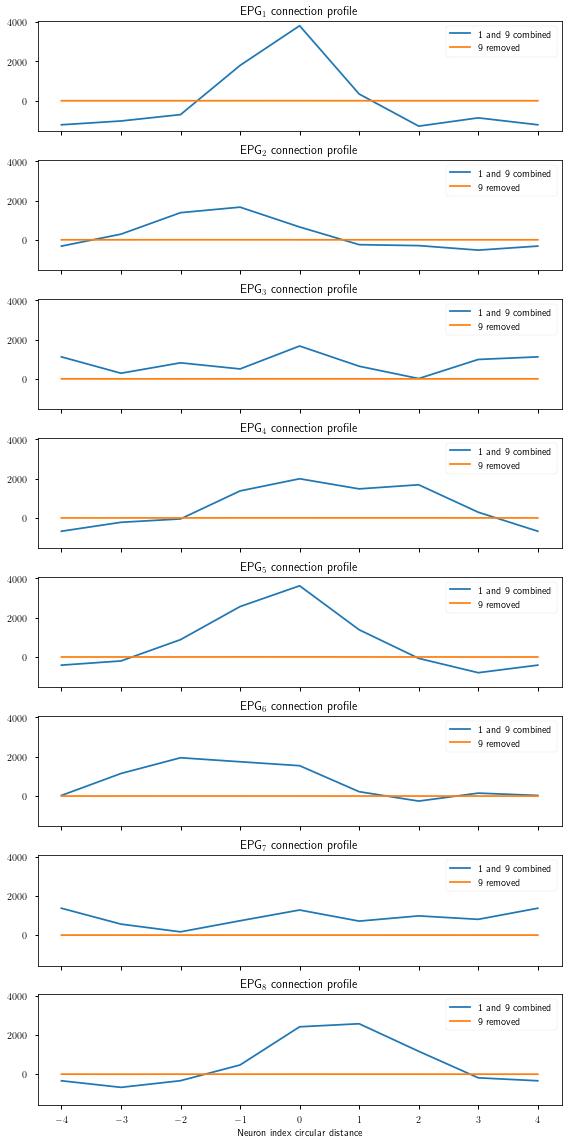

In [12]:
def plot_profiles(matrix, axs):
	N = np.arange(matrix.shape[0]+1)
	mu, stddev = get_circulant_matrix_profile(matrix)
	N -= matrix.shape[0]//2
	mu = np.roll(mu, matrix.shape[0]//2)
	stddev = np.roll(stddev, matrix.shape[0]//2)

	unrolled_matrix = roll_matrix_rows(matrix, (matrix.shape[0]//2) - np.arange(matrix.shape[0]))
	for n,ax in zip(range(unrolled_matrix.shape[0]), axs):
		ax.plot(N, circular_concat(unrolled_matrix[n,:]))

fig, axs = plt.subplots(8, 1, figsize=(8,16), sharey=True, sharex=True)

plot_profiles(simplified_connectivity_matrix_fly_janelia, axs)
plot_profiles(simplified_connectivity_matrix_fly_janelia_9_neurons, axs)

for n, ax in enumerate(axs):
	ax.set_title(f'EPG$_{n+1}$ connection profile')
	ax.legend(['1 and 9 combined','9 removed'])
axs[-1].set_xlabel('Neuron index circular distance')

plt.tight_layout()
plt.savefig('plots/network-connection-profiles-with-and-without-neuron-9.pdf')
plt.show()